<a href="https://colab.research.google.com/github/edisonmoy/Textualism/blob/master/Hyperparameter_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparamter Optimization
Working with Supreme Court Written Opinions, using GloVe to create word embeddings. Below are observations for hyperparameter tuning.

### Load Data

In [ ]:
# Load model
import os
from google.colab import drive

# Suppress warnings (dangerous)
import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive', force_remount=True)
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content


### Loss Plotting Functions

In [ ]:
import matplotlib.pyplot as plt

def find_intersection(train, validation):
  intersections = []
  for x,y in train:
    for iteration, val in validation:
      if x >= iteration - 200 and x < iteration + 200 and y <= val:
        return x,y

def plot_loss(year, loss_data):
  losses, validation_losses = loss_data

  # Plot all data
  all_data = [(x[0],x[1])  for lst in losses for x in lst]
  # epoch_avg_data = [ (sum(batch for batch,_ in lst)/len(lst), sum(n for _,n in lst)/len(lst)) for lst in losses]
  validation_data = [(x[0],x[1])  for lst in validation_losses for x in lst ]
  plt.title(str(year) + " data: loss curve")
  plt.ylabel("Loss")
  plt.xlabel("Iteration")
  plt.plot(*zip(*all_data), label="Training")
  plt.plot(*zip(*validation_data), label="Validation")
  # Find intersection
  # x ,y = find_intersection(all_data, validation_data)
  # print("Overfit at "+str(x))
  # plt.plot(x, y, 'ro')
  plt.legend()
  plt.show()


  validation_r = [(x[0],x[1]) for x in validation_data if x[0] > 1000 and x[0] < 2000]

  all_r = [(x[0],x[1]) for x in all_data if x[0] > 1000 and x[0] < 2000]

  # print(validation_r)
  # print(all_r)


  # Plot for loss values less than 1
  validation_data = [(x[0],x[1])  for lst in validation_losses for x in lst if x[1] < 1]
  all_data = [(x[0],x[1])  for lst in losses for x in lst if x[1] < 1 ]
  plt.title(str(year) + " data: loss curve for values less than 1")
  plt.ylabel("Loss")
  plt.xlabel("Iteration")
  plt.plot(*zip(*all_data), label="Training")
  plt.plot(*zip(*validation_data), label="Validation")
  plt.legend()
  plt.show()
  return


## Model Training Functions

In [ ]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os as os
from sklearn.model_selection import train_test_split


class GloveDataset:
	def __init__(self, text, n_words=200000, window_size=5):
		    self._window_size = window_size
		    self._tokens = text.split(" ")[:n_words]
		    word_counter = Counter()
		    word_counter.update(self._tokens)
		    #Might do some changes here to reduce the Size of the vocabulary
		    self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
		    self._id2word = {i:w for w, i in self._word2id.items()}
		    self._vocab_len = len(self._word2id)

		    self._id_tokens = [self._word2id[w] for w in self._tokens]

		    self._create_coocurrence_matrix()

		    print("\t# of words: {}".format(len(self._tokens)))
		    print("\tVocabulary length: {}".format(self._vocab_len))

	def _create_coocurrence_matrix(self):
		cooc_mat = defaultdict(Counter)
		for i, w in enumerate(self._id_tokens):
			start_i = max(i - self._window_size, 0)
			end_i = min(i + self._window_size + 1, len(self._id_tokens))
			for j in range(start_i, end_i):
				if i != j:
					c = self._id_tokens[j]
					cooc_mat[w][c]=1.

		for i, w in enumerate(self._id_tokens):
			start_i = max(i - self._window_size, 0)
			end_i = min(i + self._window_size + 1, len(self._id_tokens))
			for j in range(start_i, end_i):
				if i != j:
					c = self._id_tokens[j]
					cooc_mat[w][c] += 1 / abs(j-i)
			self._i_idx=list()
			self._j_idx=list()
			self._xij=list()

		#Create indexes and x values tensors
		for w, cnt in cooc_mat.items():
			for c, v in cnt.items():
				self._i_idx.append(w)
				self._j_idx.append(c)
				self._xij.append(v)

		self._i_idx = torch.LongTensor(self._i_idx)
		self._j_idx = torch.LongTensor(self._j_idx)
		self._xij = torch.FloatTensor(self._xij)

	def get_batches(self, batch_size):
		#Generate random idx
		rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

		for p in range(0, len(rand_ids), batch_size):
		    batch_ids = rand_ids[p:p+batch_size]
		    yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]


def get_batches(self, batch_size):
    #Generate random idx
    rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

    for p in range(0, len(rand_ids), batch_size):
        batch_ids = rand_ids[p:p+batch_size]
        yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]


class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x

def weight_func(x, x_max, alpha):
	wx = (x/x_max)**alpha
	wx = torch.min(wx, torch.ones_like(wx))
	return wx

def wmse_loss(weights, inputs, targets):
	loss = weights * F.mse_loss(inputs, targets, reduction='none')
	return torch.mean(loss)

def reconstruct_sentence(meta_arr):
	#Reconstruct sentence as string from array of words
	clean_sentence_helper_arr=[]
	for list_words in meta_arr:
		help_sentence=' '.join(word for word in list_words)
		clean_sentence_helper_arr.append(help_sentence)
	return clean_sentence_helper_arr

def reconstruct_text(sentence_arr):
	helper_string=""
	for index,sentence in enumerate(sentence_arr):
		helper_string+=sentence+" "
	return helper_string


path = "drive/My Drive/Textualism/Edison + Ritvik Notebooks/GloVe Hyperparameter Search/cleaned_data/"
validation_set_size = 0.2

# Given hyperparameters and year, return loss values
def train_model(year, epochs, batch_size, x_max, embed_dim, num_words, lr_val, alpha):
  losses = []
  all_validation_losses =[]

  # Load and split data into train/validation sets
  print("Loading data from "+ str(year))
  sen_arr=np.load(path + "Sentence_Array_Justia_"+str(year)+".npy", allow_pickle=True)
  sen_arr_train, sen_arr_validation = train_test_split(sen_arr,test_size=validation_set_size) 

  #Process training data
  print("\nProcessing training data... ")
  sentence_arr_train = reconstruct_sentence(sen_arr_train)
  sen_text_train = reconstruct_text(sentence_arr_train)
  dataset_train = GloveDataset(sen_text_train,num_words)
  # np.save("Words_dict",dataset_train._id2word)
  n_batches_train = int(len(dataset_train._xij) / batch_size)
  glove_train = GloveModel(dataset_train._vocab_len, embed_dim)
  optimizer_train = optim.Adagrad(glove_train.parameters(), lr=lr_val)

  #Process validation data
  print("\nProcessing validation data... ")
  sentence_arr_validation = reconstruct_sentence(sen_arr_validation)
  sen_text_validation = reconstruct_text(sentence_arr_validation)
  dataset_validation = GloveDataset(sen_text_validation,num_words)
  n_batches_validation = int(len(dataset_validation._xij) / batch_size)

  # np.save("Words_dict",dataset_validation._id2word)

  
  print ("\nStart Training") 
  loss_list = []
  validation_loss = []
  iteration_i = 0
  for e in range(1, epochs+1):
    loss_per_batch = []
    validation_loss_per_epoch = []
    batch_i = 0
    for x_ij, i_idx, j_idx in dataset_train.get_batches(batch_size):
      batch_i += 1
      iteration_i += 1
      optimizer_train.zero_grad()
      outputs = glove_train(i_idx, j_idx)
      weights_x = weight_func(x_ij, x_max, alpha)
      loss = wmse_loss(weights_x, outputs, torch.log(x_ij))
      loss_list.append(loss.item())
      # np.save(path+"Losses_test_Embed_Dim="+str(embed_dim)+"_lr="+str(lr_val),np.array(loss_list))
      loss.backward()
      optimizer_train.step()
      if batch_i % 100 == 0:
        loss_per_batch.append((iteration_i, np.mean(loss_list[-20:])))
        print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, epochs, batch_i, n_batches_train, np.mean(loss_list[-20:])))
    
      # Run validation set after each 200th iteration
      if batch_i % 200 == 0:
        validation_loss_temp = []
        for x_ij, i_idx, j_idx in dataset_validation.get_batches(batch_size):
          outputs = glove_train(i_idx, j_idx)
          weights_x = weight_func(x_ij, x_max, alpha)
          loss = wmse_loss(weights_x, outputs, torch.log(x_ij))
          validation_loss_temp.append(loss.item())
        validation_loss_per_epoch.append((iteration_i, np.mean(validation_loss_temp[-20:])))
        print("Epoch: {}/{} \t Validation \t \t Loss: {}".format(e, epochs, np.mean(validation_loss_temp[-20:])))

    # End of epoch
    print("---------------------------------------------")
    #Save Weights after each epoch
    # print("Saving model...")
    # np.save(path+"Weight_Matrix1_Embed_Dimension_"+str(EMBED_DIM)+"_lr="+str(lr_helper), glove_train.wi.weight.detach().numpy())
    # np.save(path+"Weight_Matrix2_Embed_Dimension_"+str(EMBED_DIM)+"_lr="+str(lr_helper), glove_train.wj.weight.detach().numpy())
    # np.save(path+"ID2WORD_Embed_EMBED_DIM="+str(EMBED_DIM)+"_lr="+str(lr_helper),dataset_train._id2word)
    # np.save(path+"WORD2ID_Embed_EMBED_DIM="+str(EMBED_DIM)+"_lr="+str(lr_helper),dataset_train._word2id)
    # torch.save(glove_train.state_dict(), "text8.pt")
  
    # Update losses
    all_validation_losses.append(validation_loss_per_epoch)
    losses.append(loss_per_batch)
  return losses , all_validation_losses


## Hyperparameter Tuning
Adjust hyperparameters and observe loss.

### Trial 1
4/13/2020

Using initial hyperparameters from Javed's code.

In [ ]:
epochs    	= 10
batch_size 	= 1000
x_max 	  	= 10
embed_dim 	= 200
num_words   = 1000000
lr_val      = 0.1
alpha 		  = 0.75

year = 1960

loss_data_initial = train_model(1960, epochs, batch_size, x_max, embed_dim, num_words, lr_val, alpha)

Loading data from 1960

Processing training data... 
	# of words: 670283
	Vocabulary length: 15760

Processing validation data... 
	# of words: 165084
	Vocabulary length: 9255

Start Training
Epoch: 1/10 	 Batch: 100/1490 	 Loss: 5.250277185440064
Epoch: 1/10 	 Batch: 200/1490 	 Loss: 4.235516083240509
Epoch: 1/10 	 Validation 	 	 Loss: 3.4028526306152345
Epoch: 1/10 	 Batch: 300/1490 	 Loss: 3.576234519481659
Epoch: 1/10 	 Batch: 400/1490 	 Loss: 3.1245848178863525
Epoch: 1/10 	 Validation 	 	 Loss: 2.452025556564331
Epoch: 1/10 	 Batch: 500/1490 	 Loss: 2.8655457735061645
Epoch: 1/10 	 Batch: 600/1490 	 Loss: 2.5860704302787783
Epoch: 1/10 	 Validation 	 	 Loss: 1.9928409516811372
Epoch: 1/10 	 Batch: 700/1490 	 Loss: 2.389269995689392
Epoch: 1/10 	 Batch: 800/1490 	 Loss: 2.15537291765213
Epoch: 1/10 	 Validation 	 	 Loss: 1.638657009601593
Epoch: 1/10 	 Batch: 900/1490 	 Loss: 2.056201958656311
Epoch: 1/10 	 Batch: 1000/1490 	 Loss: 1.9197291016578675
Epoch: 1/10 	 Validation 	 	 L

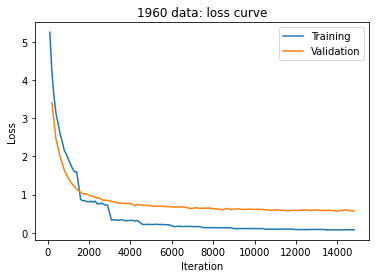

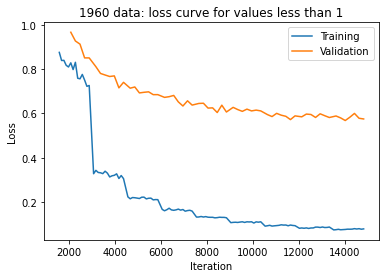

In [ ]:
%matplotlib inline
plot_loss(year, loss_data_initial)


#### Observations

Model begins to overfit at 1800 iterations.

### Trial 2
Reduce learning rate to 0.02 and batch size 32.



In [ ]:
epochs    	= 30
batch_size 	= 1000
x_max 	  	= 10
embed_dim 	= 200
num_words   = 1000000
lr_val      = 0.1
alpha 		  = 0.75

year = 1960

loss_data_2 = train_model(1960, epochs, batch_size, x_max, embed_dim, num_words, lr_val, alpha)

Loading data from 1960

Processing training data... 
	# of words: 669542
	Vocabulary length: 15937

Processing validation data... 
	# of words: 165825
	Vocabulary length: 9082

Start Training
Epoch: 1/30 	 Batch: 100/1494 	 Loss: 5.1940998315811155
Epoch: 1/30 	 Batch: 200/1494 	 Loss: 4.15242748260498
Epoch: 1/30 	 Validation 	 	 Loss: 3.462913525104523
Epoch: 1/30 	 Batch: 300/1494 	 Loss: 3.627926993370056
Epoch: 1/30 	 Batch: 400/1494 	 Loss: 3.185357928276062
Epoch: 1/30 	 Validation 	 	 Loss: 2.465658175945282
Epoch: 1/30 	 Batch: 500/1494 	 Loss: 2.8484874248504637
Epoch: 1/30 	 Batch: 600/1494 	 Loss: 2.554150974750519
Epoch: 1/30 	 Validation 	 	 Loss: 1.9869791090488433
Epoch: 1/30 	 Batch: 700/1494 	 Loss: 2.32772536277771
Epoch: 1/30 	 Batch: 800/1494 	 Loss: 2.2381221532821653
Epoch: 1/30 	 Validation 	 	 Loss: 1.6522817611694336
Epoch: 1/30 	 Batch: 900/1494 	 Loss: 2.027312308549881
Epoch: 1/30 	 Batch: 1000/1494 	 Loss: 1.9211668252944947
Epoch: 1/30 	 Validation 	 	 Lo

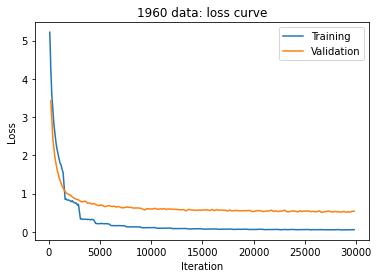

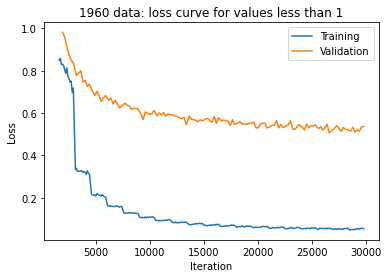

In [ ]:
plot_loss(year, loss_data_2)

### Trial 3
Further reduce learning rate


In [ ]:
epochs    	= 30
batch_size 	= 1000
x_max 	  	= 10
embed_dim 	= 200
num_words   = 1000000
lr_val      = 0.1
alpha 		  = 0.75

year = 1961

loss_data_3 = train_model(1960, epochs, batch_size, x_max, embed_dim, num_words, lr_val, alpha)

Loading data from 1960

Processing training data... 
	# of words: 667791
	Vocabulary length: 15896

Processing validation data... 
	# of words: 167576
	Vocabulary length: 9137

Start Training
Epoch: 1/30 	 Batch: 100/1490 	 Loss: 5.139496159553528
Epoch: 1/30 	 Batch: 200/1490 	 Loss: 4.162753009796143
Epoch: 1/30 	 Validation 	 	 Loss: 3.4054219126701355
Epoch: 1/30 	 Batch: 300/1490 	 Loss: 3.606582152843475
Epoch: 1/30 	 Batch: 400/1490 	 Loss: 3.1860860109329225
Epoch: 1/30 	 Validation 	 	 Loss: 2.448739010095596
Epoch: 1/30 	 Batch: 500/1490 	 Loss: 2.8094343543052673
Epoch: 1/30 	 Batch: 600/1490 	 Loss: 2.494460380077362
Epoch: 1/30 	 Validation 	 	 Loss: 1.9333857119083404
Epoch: 1/30 	 Batch: 700/1490 	 Loss: 2.365448832511902
Epoch: 1/30 	 Batch: 800/1490 	 Loss: 2.20329909324646
Epoch: 1/30 	 Validation 	 	 Loss: 1.6690862774848938
Epoch: 1/30 	 Batch: 900/1490 	 Loss: 1.957932460308075
Epoch: 1/30 	 Batch: 1000/1490 	 Loss: 1.9046151101589204
Epoch: 1/30 	 Validation 	 	 L

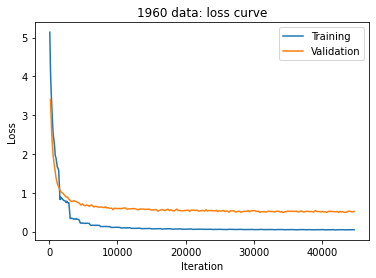

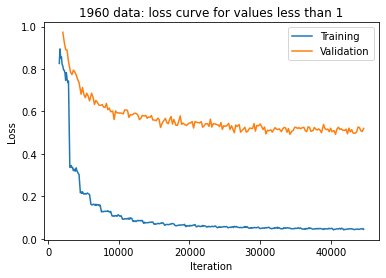

In [ ]:
plot_loss(1960, loss_data_3)

### Trial 4
Reduce embedding dim

In [ ]:
epochs    	= 20
batch_size 	= 1000
x_max 	  	= 10
embed_dim 	= 100
num_words   = 1000000
lr_val      = 0.02
alpha 		  = 0.75

year = 1960

loss_data_4 = train_model(1960, epochs, batch_size, x_max, embed_dim, num_words, lr_val, alpha)

Loading data from 1960

Processing training data... 
	# of words: 668917
	Vocabulary length: 15855

Processing validation data... 
	# of words: 166450
	Vocabulary length: 9140

Start Training
Epoch: 1/20 	 Batch: 100/1492 	 Loss: 3.382824981212616
Epoch: 1/20 	 Batch: 200/1492 	 Loss: 3.086980414390564
Epoch: 1/20 	 Validation 	 	 Loss: 2.754948341846466
Epoch: 1/20 	 Batch: 300/1492 	 Loss: 2.8941606163978575
Epoch: 1/20 	 Batch: 400/1492 	 Loss: 2.8196967244148254
Epoch: 1/20 	 Validation 	 	 Loss: 2.348391020298004
Epoch: 1/20 	 Batch: 500/1492 	 Loss: 2.6851211190223694
Epoch: 1/20 	 Batch: 600/1492 	 Loss: 2.6328994154930117
Epoch: 1/20 	 Validation 	 	 Loss: 2.1824914276599885
Epoch: 1/20 	 Batch: 700/1492 	 Loss: 2.5577070355415343
Epoch: 1/20 	 Batch: 800/1492 	 Loss: 2.427338922023773
Epoch: 1/20 	 Validation 	 	 Loss: 2.0382370054721832
Epoch: 1/20 	 Batch: 900/1492 	 Loss: 2.3775506258010863
Epoch: 1/20 	 Batch: 1000/1492 	 Loss: 2.265264022350311
Epoch: 1/20 	 Validation 	 

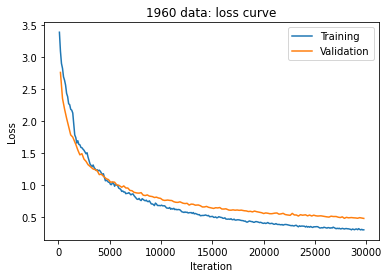

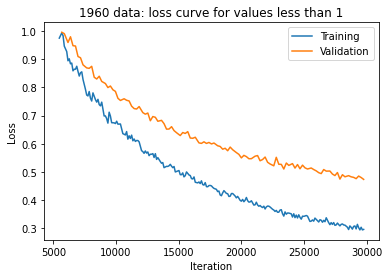

In [ ]:
plot_loss(1960, loss_data_4)

### Trial 5
Embedding dim=100, learning rate = .008

In [ ]:
epochs    	= 50
batch_size 	= 1000
x_max 	  	= 10
embed_dim 	= 100
num_words   = 1000000
lr_val      = 0.008
alpha 		  = 0.75

year = 1960

loss_data_5 = train_model(1960, epochs, batch_size, x_max, embed_dim, num_words, lr_val, alpha)

Loading data from 1960

Processing training data... 
	# of words: 667058
	Vocabulary length: 15921

Processing validation data... 
	# of words: 168309
	Vocabulary length: 9038

Start Training
Epoch: 1/50 	 Batch: 100/1495 	 Loss: 3.6141238451004027
Epoch: 1/50 	 Batch: 200/1495 	 Loss: 3.4001309752464293
Epoch: 1/50 	 Validation 	 	 Loss: 3.0353455424308775
Epoch: 1/50 	 Batch: 300/1495 	 Loss: 3.4140251874923706
Epoch: 1/50 	 Batch: 400/1495 	 Loss: 3.3406847953796386
Epoch: 1/50 	 Validation 	 	 Loss: 2.998033332824707
Epoch: 1/50 	 Batch: 500/1495 	 Loss: 3.2784379720687866
Epoch: 1/50 	 Batch: 600/1495 	 Loss: 3.2393515586853026
Epoch: 1/50 	 Validation 	 	 Loss: 2.8718465089797975
Epoch: 1/50 	 Batch: 700/1495 	 Loss: 3.200687491893768
Epoch: 1/50 	 Batch: 800/1495 	 Loss: 3.1218884706497194
Epoch: 1/50 	 Validation 	 	 Loss: 2.8261628270149233
Epoch: 1/50 	 Batch: 900/1495 	 Loss: 3.1526919484138487
Epoch: 1/50 	 Batch: 1000/1495 	 Loss: 3.083470106124878
Epoch: 1/50 	 Validation

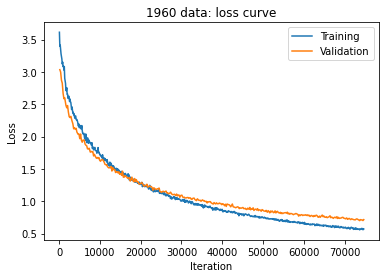

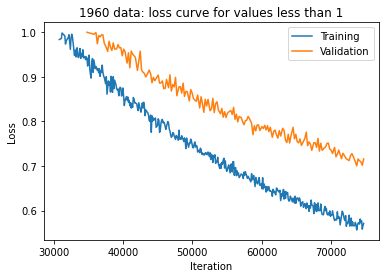

In [ ]:
plot_loss(1960, loss_data_5)

### Trial 6
Using embedding dimension=100, try to find optimal learning rate.

In [ ]:
epochs    	= 30
batch_size 	= 1000
x_max 	  	= 10
embed_dim 	= 200
num_words   = 1000000
lr_val      = 0.05
alpha 		  = 0.75

year = 1960

loss_data_6 = train_model(1960, epochs, batch_size, x_max, embed_dim, num_words, lr_val, alpha)

Loading data from 1960

Processing training data... 
	# of words: 666858
	Vocabulary length: 15839

Processing validation data... 
	# of words: 168509
	Vocabulary length: 9130

Start Training
Epoch: 1/30 	 Batch: 100/1490 	 Loss: 5.774786496162415
Epoch: 1/30 	 Batch: 200/1490 	 Loss: 5.117925691604614
Epoch: 1/30 	 Validation 	 	 Loss: 4.252560639381409
Epoch: 1/30 	 Batch: 300/1490 	 Loss: 4.656922626495361
Epoch: 1/30 	 Batch: 400/1490 	 Loss: 4.359308052062988
Epoch: 1/30 	 Validation 	 	 Loss: 3.458259654045105
Epoch: 1/30 	 Batch: 500/1490 	 Loss: 3.989473748207092
Epoch: 1/30 	 Batch: 600/1490 	 Loss: 3.7550788164138793
Epoch: 1/30 	 Validation 	 	 Loss: 2.9425783514976502
Epoch: 1/30 	 Batch: 700/1490 	 Loss: 3.58662486076355
Epoch: 1/30 	 Batch: 800/1490 	 Loss: 3.383362054824829
Epoch: 1/30 	 Validation 	 	 Loss: 2.6470949411392213
Epoch: 1/30 	 Batch: 900/1490 	 Loss: 3.237979257106781
Epoch: 1/30 	 Batch: 1000/1490 	 Loss: 3.055672764778137
Epoch: 1/30 	 Validation 	 	 Loss

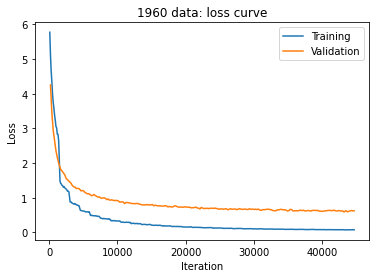

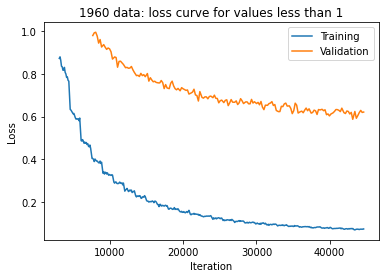

In [ ]:
plot_loss(1960, loss_data_6)

## Testing validation sets


In [ ]:
epochs    	= 2
batch_size 	= 1000
x_max 	  	= 10
embed_dim 	= 200
num_words   = 1000000
lr_val      = 0.1
alpha 		  = 0.75

year = 1960

loss_data_play = train_model(1960, epochs, batch_size, x_max, embed_dim, num_words, lr_val, alpha)

Loading data from 1960

Processing training data... 
	# of words: 667483
	Vocabulary length: 15874

Processing validation data... 
	# of words: 167884
	Vocabulary length: 9098

Start Training
Epoch: 1/2 	 Batch: 100/1490 	 Loss: 5.180870008468628
Epoch: 1/2 	 Batch: 200/1490 	 Loss: 4.257130491733551
Epoch: 1/2 	 Validation 	 	 Loss: 3.4157326936721804
Epoch: 1/2 	 Batch: 300/1490 	 Loss: 3.5855209589004517
Epoch: 1/2 	 Batch: 400/1490 	 Loss: 3.1551926732063293
Epoch: 1/2 	 Validation 	 	 Loss: 2.4729918360710146
Epoch: 1/2 	 Batch: 500/1490 	 Loss: 2.8000210762023925
Epoch: 1/2 	 Batch: 600/1490 	 Loss: 2.5431644320487976
Epoch: 1/2 	 Validation 	 	 Loss: 1.9448731303215028
Epoch: 1/2 	 Batch: 700/1490 	 Loss: 2.3573936104774473
Epoch: 1/2 	 Batch: 800/1490 	 Loss: 2.1939874410629274
Epoch: 1/2 	 Validation 	 	 Loss: 1.618382066488266
Epoch: 1/2 	 Batch: 900/1490 	 Loss: 2.005899739265442
Epoch: 1/2 	 Batch: 1000/1490 	 Loss: 1.9077462613582612
Epoch: 1/2 	 Validation 	 	 Loss: 1.374

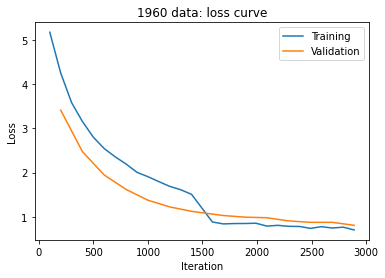

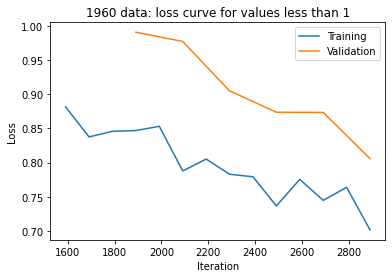

In [ ]:
plot_loss(1960, loss_data_play)

#### Bayesian Hyperparameter Optimization
Link: https://pypi.org/project/bayesian-optimization/



In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
pbounds = {'year': (1960, 1960), 
           'epochs': (2, 10),
           'batch_size': (20, 1000), 
           'x_max': (10, 10), 
           'embed_dim': (200, 200), 
           'num_words': (1000000, 1000000), 
           'lr_val': (0.01, 0.05), 
           'alpha': (0.75, 0.75)}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(
    init_points=2,
    n_iter=3,
)
print(optimizer.max)

|   iter    |  target   |   alpha   | batch_... | embed_dim |  epochs   |  lr_val   | num_words |   x_max   |   year    |
-------------------------------------------------------------------------------------------------------------------------
Loading data from 1960.0


FileNotFoundError: ignored